In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import pickle
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
from scipy.spatial import ConvexHull
from GPyOpt.util.general import get_quantiles
import plotly.graph_objs as go
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
import json
import random

In [2]:
# my own tools
from bgotools.suggest_experiments import suggest_next 
from bgotools.my_acquisitions import EI_below_hull
from bgotools.my_hull_funcs import my_hull_funcs 
from bgotools.set_pool import set_pool
from bgotools.my_acquisitions import EI_hull_area

In [3]:
# for training data
def f(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [4]:
# read the query data formation_energy, clex, corr
data_save = pd.read_csv('./BGO_EI_data',sep='\s+')




In [5]:

data = data_save

In [6]:
# process data 
data['clex()'] = data['clex()'].apply(f)
calculated_data = data['clex()'].notnull()
# calculated data
X_data_all = data[calculated_data]['comp(a)']
Y_data_all = data[calculated_data]['clex()']

len(X_data_all)#number of calculated data

58165

In [7]:
data

,configname,selected,comp(a),formation_energy,clex(),corr(0),corr(1),corr(2),corr(3),corr(4),...,corr(238),corr(239),corr(240),corr(241),corr(242),corr(243),corr(244),corr(245),corr(246),corr(247)
0,SCEL1_1_1_1_0_0_0/0,1,1.000000,0.00000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,SCEL1_1_1_1_0_0_0/1,1,0.875000,-0.03401745,-0.035452,1.0,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,SCEL1_1_1_1_0_0_0/10,1,0.625000,-0.08774064,-0.085923,1.0,0.500000,0.500000,0.000000,0.500000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,SCEL1_1_1_1_0_0_0/100,1,0.625000,-0.06716164,-0.068766,1.0,0.500000,0.000000,0.500000,0.500000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.5,0.000000,0.000000,0.000000
4,SCEL1_1_1_1_0_0_0/101,1,0.500000,-0.08761127,-0.077558,1.0,1.000000,0.000000,0.500000,0.500000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.5,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58160,SCEL3_3_1_1_0_1_2/995,1,0.291667,unknown,-0.040703,1.0,0.500000,0.833333,0.666667,0.833333,...,0.055556,0.166667,0.333333,0.333333,0.166667,0.166667,0.0,0.000000,0.166667,0.166667
58161,SCEL3_3_1_1_0_1_2/996,1,0.458333,unknown,-0.064093,1.0,0.500000,0.666667,0.500000,0.500000,...,0.055556,0.166667,0.000000,0.000000,0.055556,0.000000,0.0,0.000000,0.000000,0.000000
58162,SCEL3_3_1_1_0_1_2/997,1,0.375000,unknown,-0.053905,1.0,0.500000,0.666667,0.666667,0.666667,...,0.055556,0.111111,0.000000,0.333333,0.166667,0.000000,0.0,0.111111,0.111111,0.111111
58163,SCEL3_3_1_1_0_1_2/998,1,0.458333,unknown,-0.046311,1.0,0.666667,0.500000,0.500000,0.500000,...,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.0,0.000000,0.055556,0.055556


In [8]:
# get convex hull 
my_hull = my_hull_funcs(X_data_all,Y_data_all)
my_hull.get_bottom_hull()
true_convex_hull, true_convex_hull_index = my_hull.bt_hull_points, my_hull.bt_hull_vertices
hull_function = my_hull.bt_hull_facets
my_hull.shoelace_area()

In [9]:
random.seed(101)
#Number of initial data pool (user)
N_init = 30
init_idxs = random.sample(range(len(data)),N_init)
#init_idxs = random.sample(range(399),N_init)

if data[data['comp(a)']==0].index[0] not in init_idxs:
    init_idxs.append(data[data['comp(a)']==0].index[0])
if data[data['comp(a)']==1].index[0] not in init_idxs:
    init_idxs.append(data[data['comp(a)']==1].index[0])

In [10]:
# start making inputs for GPyOpt
# Y property for training/prediction
Y_name = 'clex()' 
# training pool
N_train = len(init_idxs)
train_index = init_idxs
# design pool
N_design = len(data)
design_index = (range(len(data)))
# corrs 
num_corrs = sum('corr' in s for s in data.columns)
selected_corrs = np.ones(num_corrs) # all correlation functions
# set_pool make the training pool and design pool according to the above settings
my_pool = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)

In [11]:
len(my_pool.train_X[0])

248

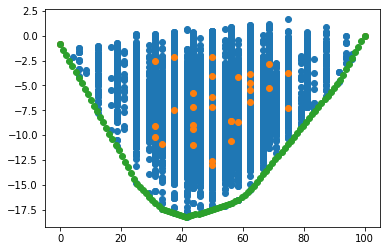

In [12]:
# interactive plot calculated
# visualization of the DFT hull 


plt.scatter(data['comp(a)']*100, data['clex()']*1000/8)
plt.scatter( my_pool.train_comp*100, my_pool.train_Y*1000/8)
hull_x_grid = np.linspace(0,1,100)
plt.scatter(hull_x_grid*100,my_hull.bt_hull_facets(hull_x_grid)*1000/8)
#fig.add_scatter(x = hull_x_grid*100,y = my_Af.predicted_hull.bt_hull_facets(hull_x_grid)*1000/8)
#plt.scatter(hull_x_grid*100,known_hull.bt_hull_facets(hull_x_grid)*1000/8)
plt.show()

In [13]:
# remind properties inside my_pool
'''
my_pool.train_X
my_pool.train_Y 
my_pool.train_comp
my_pool.design_X
my_pool.design_comp
'''
## define some parameters for fitting
max_iteration = 10
tolerance = 1e-3
fixed_noise=1e-6



In [14]:
# remind the initial training data pool 
X_train = my_pool.train_X
Y_train = my_pool.train_Y_nd
done_experiments_id_list = [x for x in my_pool.train_index]
# remind the design data pool
X_design = my_pool.design_X
#design_idxs
# remind the formation energy calculation from the ECIs
#eci_list
#CE_formation_energy
# 
# 
# remind the true ground state line
true_convex_hull_X = data['comp(a)'][true_convex_hull_index]
true_convex_hull_Y = data['clex()'][true_convex_hull_index]
X_list = np.linspace(0,1,100)

In [15]:
GPModelClass=GPy.models.GPRegression

In [16]:
kernel = GPy.kern.RBF(X_train.shape[1], ARD=True)
model = GPModelClass(X_train, Y_train, kernel)
model.Gaussian_noise.variance.constrain_fixed(fixed_noise)
model.optimize_restarts(20, verbose=False)

In [19]:
EI_below_hull?

Init signature:
EI_below_hull(
    design_X,
    design_comp,
    model,
    hull_function,
    xi=0.0,
    mode='min',
)
Docstring:      <no docstring>
Init docstring:
Compute the Expected Improvement at (X_i, comp_i). 

design_X: Compositions of the training data set

design_comp: Compositions of the design data set

model: BG.regression

mode: minimize or maximize the current Y profile, default is min

xi: parameter for EI, read Brochu's paper for details, a safe value of 0.0 is good
File:           /opt/anaconda3/lib/python3.7/site-packages/bgotools/my_acquisitions.py
Type:           type
Subclasses:     


In [17]:
known_hull = my_hull_funcs(my_pool.train_comp,my_pool.train_Y)
known_hull.get_bottom_hull()
known_hull.shoelace_area()

In [20]:
my_Af = EI_below_hull(my_pool.design_X,
                     my_pool.design_comp,
                     model,
                     my_hull.bt_hull_facets)

In [21]:
#my_Af.predicted_hull_configs

In [22]:
my_Af.EI()

array([0.0004464, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ])

In [26]:
train_index_update = my_pool.train_index

In [27]:
#start iterations from here
train_index_update = train_index
my_pool_update = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)
print(len(my_pool_update.train_comp),len(my_pool_update.train_Y))
saved_model_list = []
next_experiment_id_list = []
next_experiment_idxs_list_non_duplicated = []
af_max_ei_list = []
af_ei_list = []
# Af_evolve documents all the Af/EI for all iterations
# in an Af of one iteration, we can get 
# 1. EI of hull
# 2. predicted area
# 3. predicted mean/variance of configurations
# 4. predicted hull -> all configurations
# 5. predicted hull subsets -> combinations
# 6. predicted hull functions -> for plotting the hull

Af_evolve = []


32 32


In [28]:
max_iterations = 6

In [29]:
saved_model_list = []
next_experiment_id_list = []
next_experiment_idxs_non_duplicated_list = []
af_max_ei_list = []
af_ei_list = []
# Af_evolve documents all the Af/EI for all iterations
# in an Af of one iteration, we can get 
# 1. EI of hull
# 2. predicted area
# 3. predicted mean/variance of configurations
# 4. predicted hull -> all configurations
# 5. predicted hull subsets -> combinations
# 6. predicted hull functions -> for plotting the hull

Af_evolve = []


# start optimization 
#for it in range(max_iteration):
for it in range(max_iterations):
    print('> Iteration: {}'.format(it))
    print('Number of data points observed: {}'.format(len(my_pool_update.train_Y_nd)))
    # setup model
    kernel = GPy.kern.RBF(my_pool_update.train_X.shape[1], ARD=True)
    model = GPModelClass(my_pool_update.train_X, my_pool_update.train_Y_nd, kernel)
    if fixed_noise is not None:
        model.Gaussian_noise.variance.unconstrain()
        model.Gaussian_noise.variance.constrain_fixed(fixed_noise)
        
    # start fitting
    model.optimize_restarts(20, verbose=False)
    saved_model_list.append(model)
    # fitting finished, get EI
    known_hull = my_hull_funcs(my_pool_update.train_comp,my_pool_update.train_Y)
    known_hull.get_bottom_hull()
    #####
    #####
    #####
    my_Af = EI_below_hull(my_pool_update.design_X,
                     my_pool_update.design_comp,
                     model,
                     known_hull.bt_hull_facets)
    
    my_Af.EI()
    ei = my_Af.ei 
    i = np.argmax(ei)
    af_max_ei0 = ei[i]
    Af_evolve.append(my_Af)
    af_max_ei_list.append(af_max_ei0)
    #####
    #####
    #####
    # rank configurations according to ei and pick a batch from the top
    sorted_ei = [sorted(range(len(my_Af.ei)), key=lambda i: my_Af.ei[i],reverse=True)][0]
    next_experiment_idxs_non_duplicated = []
    
    for config in sorted_ei:
        if config>sorted_ei[0]/1e5: #
            if len(next_experiment_idxs_non_duplicated)<5: # pick a batch of 5
                if config not in train_index_update:
                    next_experiment_idxs_non_duplicated.append(config)
    
    #####
    #####
    #####
    
    # determine whether next fitting is necessary 
    if af_max_ei0 / af_max_ei_list[0] <= tolerance:
        print('*** Converged (af[i] / afmax0 = {0:1.7f}) < {1:e}'.format(af_max_ei0 / af_max_ei_list[0], tolerance))
        
    # append predicted configurations to the updating training pool (observations)
    train_index_update = train_index_update + next_experiment_idxs_non_duplicated
    my_pool_update = set_pool(data,train_index_update,design_index,selected_corrs,Y_name,ternary=False)
    next_experiment_idxs_non_duplicated_list.append(next_experiment_idxs_non_duplicated)
    print('Selected Structures: {}'.format(next_experiment_idxs_non_duplicated))
    
    print('Max EI = {}'.format(af_max_ei0 / af_max_ei_list[0]))
    print('Min Energy Observed: {}'.format(my_pool_update.train_Y.min()))

> Iteration: 0
Number of data points observed: 32
Selected Structures: [23, 51719, 51464, 54356, 51808]
Max EI = 1.0
Min Energy Observed: -0.12928084
> Iteration: 1
Number of data points observed: 37
Selected Structures: [57083, 55088, 30197, 33644, 17204]
Max EI = 0.6902588796753478
Min Energy Observed: -0.12928084
> Iteration: 2
Number of data points observed: 42
Selected Structures: [21, 12625, 54065, 12576, 125]
Max EI = 0.5752276316894457
Min Energy Observed: -0.14596631
> Iteration: 3
Number of data points observed: 47
Selected Structures: [23471, 39911, 51841, 30, 7031]
Max EI = 0.2801161989362959
Min Energy Observed: -0.14596631
> Iteration: 4
Number of data points observed: 52
Selected Structures: [54287, 54176, 51819, 22207, 38647]
Max EI = 0.08868270197003775
Min Energy Observed: -0.14596631
> Iteration: 5
Number of data points observed: 57
Selected Structures: [1, 2, 3, 4, 5]
Max EI = 0.0032529158916299815
Min Energy Observed: -0.14596631


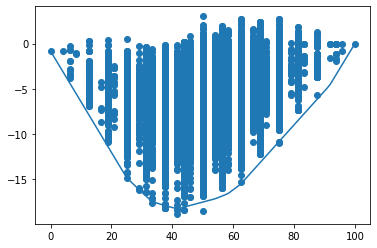

In [35]:
# interactive plot calculated
# visualization of the DFT hull 
my_Af = Af_evolve[2]

#plt.scatter(data['comp(a)']*100, data['clex()']*1000/8)
#plt.scatter( my_pool.train_comp*100, my_pool.train_Y*1000/8)
hull_x_grid = np.linspace(0,1,100)
plt.plot(hull_x_grid*100,my_hull.bt_hull_facets(hull_x_grid)*1000/8)

plt.scatter(my_Af.design_comp*100,my_Af.predictive_mean*1000/8)
#plt.scatter(hull_x_grid*100,known_hull.bt_hull_facets(hull_x_grid)*1000/8)
plt.show()